In [780]:
# %pip install holidays
# %pip install --upgrade https://github.com/dr-prodigy/python-holidays/tarball/beta


# Run the above line to install the holidays module

###Question 1

In [781]:
from datetime import datetime, timedelta
import numpy as np
from datetime import date
import holidays

In [1292]:
def get_hours(iso,peak_type,period):
    
    Eastern = ["PJM","MISO","ERCOT","SPP","NYISO"]
    Western = ["WECC","CAISO"]
    DLS = ["PJM","ERCOT","SPP","NYISO","WECC","CAISO"]

    year = int(period[0:4])
    
    
#   For input that comes in as Daily period, such as “2018-2-3” 
    if period[4] == "-":
        start = datetime.strptime(period, "%Y-%m-%d")
        end_plus_one = start + timedelta(1)
        DLS_hour_change = 0
# Check if the date is a day light saving date, if so, apply the DLS change.
        if start.weekday() ==6:
            if start.month==11 and start.day<= 7:
                DLS_hour_change = 1
            if start.month == 3 and start.day>7 and start.day<=14 :
                DLS_hour_change = -1
        
#   For input that comes in as Quarterly period, such as “2018Q2” 
# For Q1 and Q3, apply the DLS change
    elif period[4] == "Q":
        if period[5] == "1":
            start = datetime(year,1,1)
            end_plus_one = datetime(year,4,1)
            DLS_hour_change = -1
        elif period[5] == "2":
            start = datetime(year,4,1)
            end_plus_one = datetime(year,7,1)
            DLS_hour_change = 0
        elif period[5] == "3":
            start = datetime(year,7,1)
            end_plus_one = datetime(year,10,1)
            DLS_hour_change = 0
        elif period[5] == "4":
            start = datetime(year,10,1)
            end_plus_one = datetime(year+1,1,1)
            DLS_hour_change = 1
            
#   For input that comes in as Annual period, such as “2018A” 
    elif period[4:] == "A":
        start = datetime(year,1,1)
        end_plus_one = datetime(year+1,1,1)
        DLS_hour_change = 0
        
#   For input that comes in as Monthly period, such as “2018Mar” 
    elif period[5].isalpha() == True:
        month = datetime.strptime(period[4:], '%b').month  
        start = datetime(year,month, 1)
        if month == 12:
            end_plus_one = datetime(year+1,1,1)
            DLS_hour_change = 0
        else:
            end_plus_one = datetime(year,month+1, 1)
            if month == 3:
                DLS_hour_change = -1
            if month == 11:
                DLS_hour_change = 1
            else:
                DLS_hour_change = 0

    else:
        print("please enter the correct period format")
        return

    print("\nresult for", period)

    total_days = (end_plus_one-start).days
    print("total days", total_days)
    
#   Adjust for the day light saving
    flat_hours = total_days*24
    if iso in DLS :
        flat_hours += DLS_hour_change
    
#   Load the NERC holidays
    NERC_holiday_list = [ 
    "New Year's Day",
    'Memorial Day',
    'Independence Day',
    'Labor Day',
    'Thanksgiving',
    'Christmas Day']
    USA_holiday_dictionary = (holidays.UnitedStates(years = year))
    NERC_holiday=[dates for dates, name in USA_holiday_dictionary.items() if name in NERC_holiday_list]

    if iso in Eastern:
        peak_days = np.busday_count(start.strftime("%Y-%m-%d"), end_plus_one.strftime("%Y-%m-%d"),holidays=NERC_holiday)
    elif iso in Western:
        peak_days = np.busday_count(start.strftime("%Y-%m-%d"), end_plus_one.strftime("%Y-%m-%d"),holidays=NERC_holiday,
    weekmask = [1,1,1,1,1,1,0])
    else:
        print("Wrong iso, please enter the correct iso")
        return

    print("peak days", peak_days)
    
    
    if peak_type == "flat":
        print("flat hours:")
        return flat_hours
    
    if peak_type == "7x8":
        low_hours = total_days*8
        low_hours += DLS_hour_change
        print("7x8 hours:")
        return low_hours
    
    if peak_type == "onpeak":
        peak_hours = peak_days*16
        print("onpeak hours:")
        return peak_hours
    
    if peak_type == "offpeak":
        off_peak_hours = flat_hours - peak_days*16
        print("offpeak hours:")
        return off_peak_hours
    
    if peak_type == "2x16H":
        weekend_and_holidays = total_days-peak_days
        weekend_and_holiday_hours = weekend_and_holidays*16
        print("2x16H hours:")
        return weekend_and_holiday_hours
    

In [1293]:
# Running some tests to make sure the calculation is correct
get_hours("PJM","flat","2019-03-10")


result for 2019-03-10
total days 1
peak days 0
flat hours:


23

In [1294]:
for month in range(1,5):
    print(get_hours("CAISO","onpeak","2019Q"+str(month)))


result for 2019Q1
total days 90
peak days 76
onpeak hours:
1216

result for 2019Q2
total days 91
peak days 77
onpeak hours:
1232

result for 2019Q3
total days 92
peak days 77
onpeak hours:
1232

result for 2019Q4
total days 92
peak days 77
onpeak hours:
1232


###Question 2

In [785]:
# pip install dfply


In [786]:
import pandas as pd
from dfply import *
import email.utils as eutils
import time
from datetime import datetime

In [942]:
# read the data using pandas
hourly = pd.read_csv("Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv", index_col=0)
hourly

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
Date/Time,,,,,,,,,,,,,
01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31 20:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999
12/31 21:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843
12/31 22:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092


In [943]:
one_app=pd.read_csv('Assignment 2 - new.app4.csv',index_col=0).set_index('time')
one_app

,W_min
time,
6/7/2013 11:04,1142.919571
6/7/2013 11:05,371.239567
6/7/2013 11:06,367.887333
6/7/2013 11:07,702.714100
6/7/2013 11:08,1655.944450
...,...
9/17/2013 23:06,1.316350
9/17/2013 23:07,1.309550
9/17/2013 23:08,1.296950


In [1027]:
# Noted the two datafiles have slightly different datetime format, so we need to first unify them

hourly = pd.read_csv("Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv", index_col=0)
hourly.index = [datetime.strptime((i[1:-8]+str(int(i[-8:-6])-1)+i[-6:]), '%m/%d %H:%M:%S') for i in hourly.index]
# # Change the format of the timestamp, so that 1:00 means 1:00-2:00, not 0:00-1:00

hourly.index = pd.to_datetime(hourly.index,format =(" %m/%d %H:%M:%S"))           
# Change the index to timestamp format 


dt1 = datetime(2013, 1,  1,hour=0, minute=0, second=0,) 
dt2 = hourly.index[0]

diff_days = (dt1-dt2)

# calculate the difference in days and unify the years
        
hourly.index = hourly.index+diff_days

hourly


,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
2013-01-01 00:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
2013-01-01 01:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
2013-01-01 02:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
2013-01-01 03:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
2013-01-01 04:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999
2013-12-31 20:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843
2013-12-31 21:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092
2013-12-31 22:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399


In [1028]:
one_app.index = pd.to_datetime(one_app.index,format =("%m/%d/%Y %H:%M"))
# now unifing the timestamp for the single app
print(one_app.index[0])
print(hourly.index[0])

2013-06-07 11:04:00
2013-01-01 00:00:00


In [993]:
one_app

,W_min
time,
2013-06-07 11:04:00,1142.919571
2013-06-07 11:05:00,371.239567
2013-06-07 11:06:00,367.887333
2013-06-07 11:07:00,702.714100
2013-06-07 11:08:00,1655.944450
...,...
2013-09-17 23:06:00,1.316350
2013-09-17 23:07:00,1.309550
2013-09-17 23:08:00,1.296950


In [1029]:
one_app['hour_level_time'] = pd.to_datetime(one_app.index.strftime("%Y-%m-%d %H"))

# Add a new row with minute level information removed

one_app_hourly = one_app.groupby('hour_level_time').sum().rename_axis(index=None)
# sum up the hourly usage

one_app_hourly['One_app:Electricity[kW](Hourly)']  = one_app_hourly['W_min']/1000
one_app_hourly=one_app_hourly.drop(['W_min'],axis=1)
#  Changing the usage from W to KW

one_app_hourly

,One_app:Electricity[kW](Hourly)
2013-06-07 11:00:00,57.388943
2013-06-07 12:00:00,27.227961
2013-06-07 13:00:00,111.476298
2013-06-07 14:00:00,109.021960
2013-06-07 15:00:00,5.773963
...,...
2013-09-17 19:00:00,0.081495
2013-09-17 20:00:00,0.081474
2013-09-17 21:00:00,0.082655
2013-09-17 22:00:00,0.081191


In [1030]:
joined_df = hourly.join(one_app_hourly).fillna(0)
joined_df

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),One_app:Electricity[kW](Hourly)
2013-01-01 00:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,0.0
2013-01-01 01:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,0.0
2013-01-01 02:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,0.0
2013-01-01 03:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,0.0
2013-01-01 04:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,0.0
2013-12-31 20:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,0.0
2013-12-31 21:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,0.0
2013-12-31 22:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399,0.0


In [1031]:
non_zero_values = joined_df.loc[(joined_df['One_app:Electricity[kW](Hourly)']!=0)].index
print((non_zero_values==one_app_hourly.index).all())
# Check to see if the non-zero values and index match, if so this should return true and that means we have joined the two dataframes successfully

True


In [1323]:
joined_df['Total'] = joined_df.iloc[:,0:14].sum(axis=1)
joined_df['Total_without_one'] = joined_df.iloc[:,0:13].sum(axis=1)

joined_df

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),One_app:Electricity[kW](Hourly),Total,Total_without_one,weekday,month,hour
2013-01-01 00:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,0.0,11.035430,11.035430,1,1,0
2013-01-01 01:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,0.0,11.496637,11.496637,1,1,1
2013-01-01 02:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,0.0,11.757447,11.757447,1,1,2
2013-01-01 03:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,0.0,11.885034,11.885034,1,1,3
2013-01-01 04:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,0.0,12.323477,12.323477,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,0.0,5.230105,5.230105,1,12,19
2013-12-31 20:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,0.0,4.920653,4.920653,1,12,20
2013-12-31 21:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,0.0,4.441100,4.441100,1,12,21
2013-12-31 22:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399,0.0,4.086723,4.086723,1,12,22


In [1324]:
joined_df['weekday'] = joined_df.index.weekday
joined_df['month'] = joined_df.index.month
joined_df['hour'] = joined_df.index.hour
joined_df

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),One_app:Electricity[kW](Hourly),Total,Total_without_one,weekday,month,hour
2013-01-01 00:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,0.0,11.035430,11.035430,1,1,0
2013-01-01 01:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,0.0,11.496637,11.496637,1,1,1
2013-01-01 02:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,0.0,11.757447,11.757447,1,1,2
2013-01-01 03:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,0.0,11.885034,11.885034,1,1,3
2013-01-01 04:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,0.0,12.323477,12.323477,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,0.0,5.230105,5.230105,1,12,19
2013-12-31 20:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,0.0,4.920653,4.920653,1,12,20
2013-12-31 21:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,0.0,4.441100,4.441100,1,12,21
2013-12-31 22:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399,0.0,4.086723,4.086723,1,12,22


month
1     Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
11    Axes(0.125,0.11;0.775x0.77)
12    Axes(0.125,0.11;0.775x0.77)
Name: Total, dtype: object

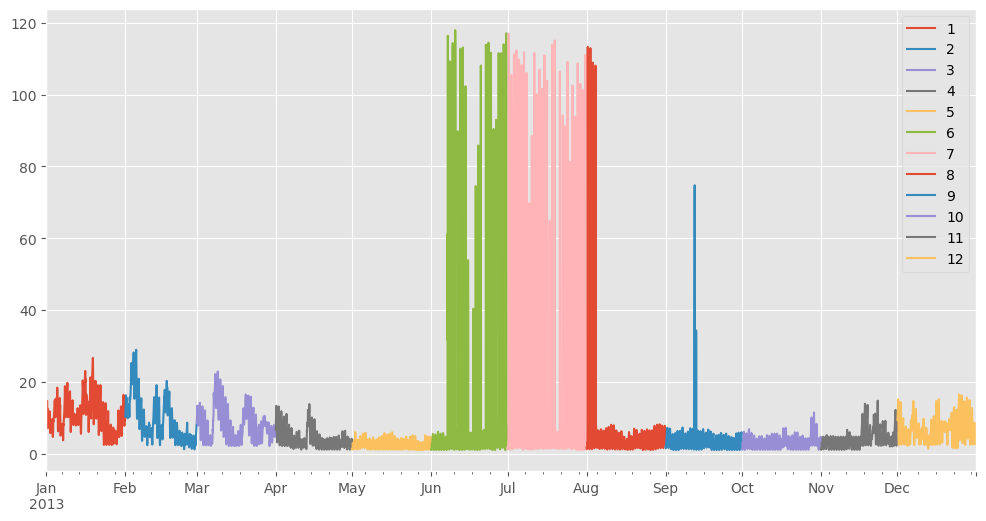

In [1331]:
import matplotlib.pyplot as plt
joined_df.groupby('month')['Total'].plot(legend=True)

month
1     Axes(0.125,0.11;0.775x0.77)
2     Axes(0.125,0.11;0.775x0.77)
3     Axes(0.125,0.11;0.775x0.77)
4     Axes(0.125,0.11;0.775x0.77)
5     Axes(0.125,0.11;0.775x0.77)
6     Axes(0.125,0.11;0.775x0.77)
7     Axes(0.125,0.11;0.775x0.77)
8     Axes(0.125,0.11;0.775x0.77)
9     Axes(0.125,0.11;0.775x0.77)
10    Axes(0.125,0.11;0.775x0.77)
11    Axes(0.125,0.11;0.775x0.77)
12    Axes(0.125,0.11;0.775x0.77)
Name: Total_without_one, dtype: object

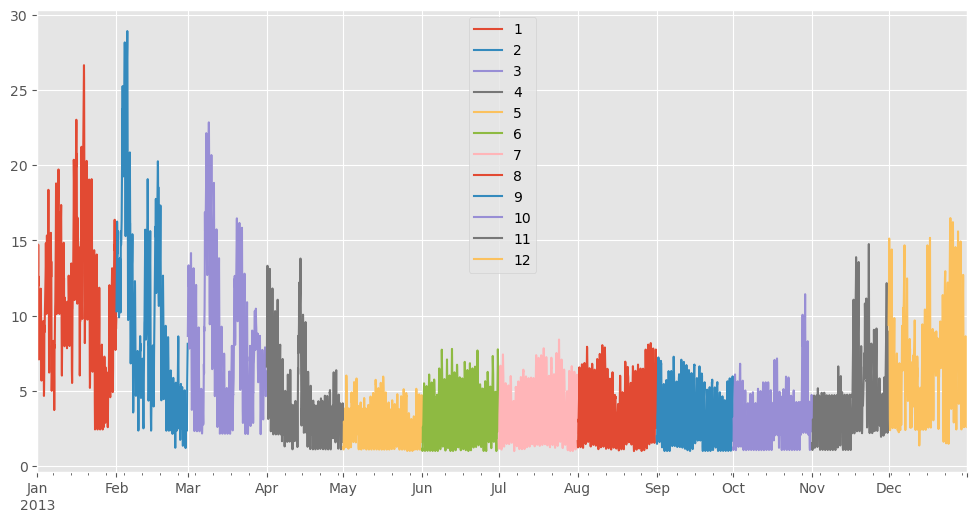

In [1329]:
joined_df.groupby('month')['Total_without_one'].plot(legend=True)

<Axes: xlabel='hour'>

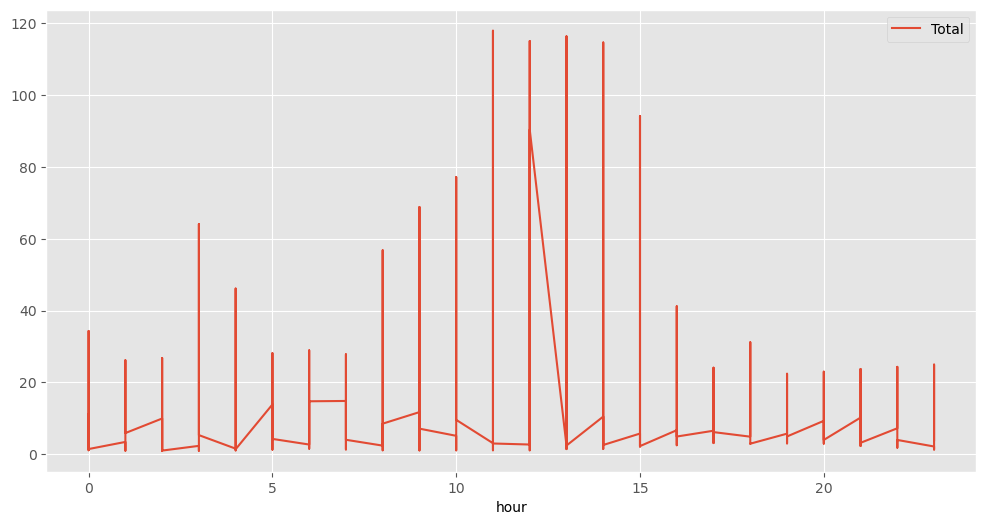

In [1335]:
joined_sort_hour=joined_df.sort_values(['hour'],ascending=True)
joined_hour = joined_sort_hour.set_index('hour')
joined_hour['Total'].plot(legend=True)

<Axes: xlabel='hour'>

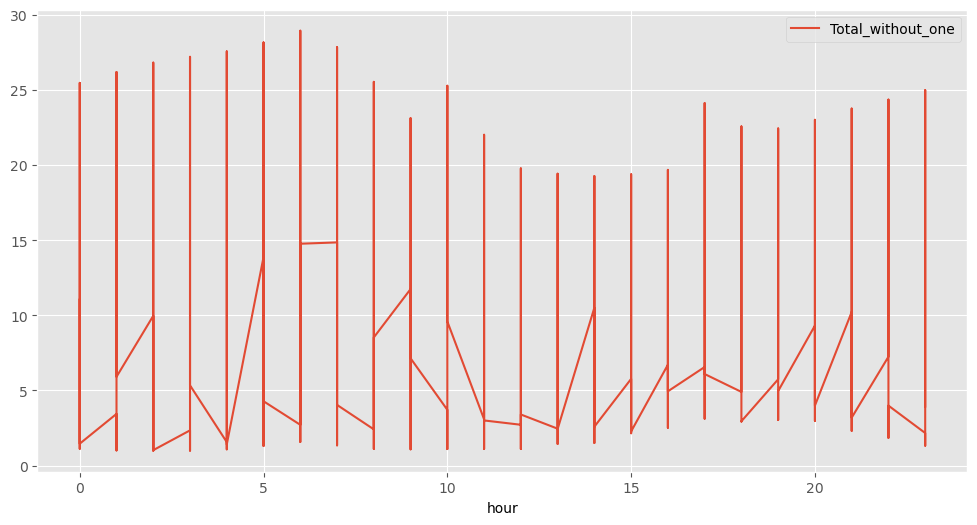

In [1337]:
joined_hour['Total_without_one'].plot(legend=True)

<Axes: xlabel='weekday'>

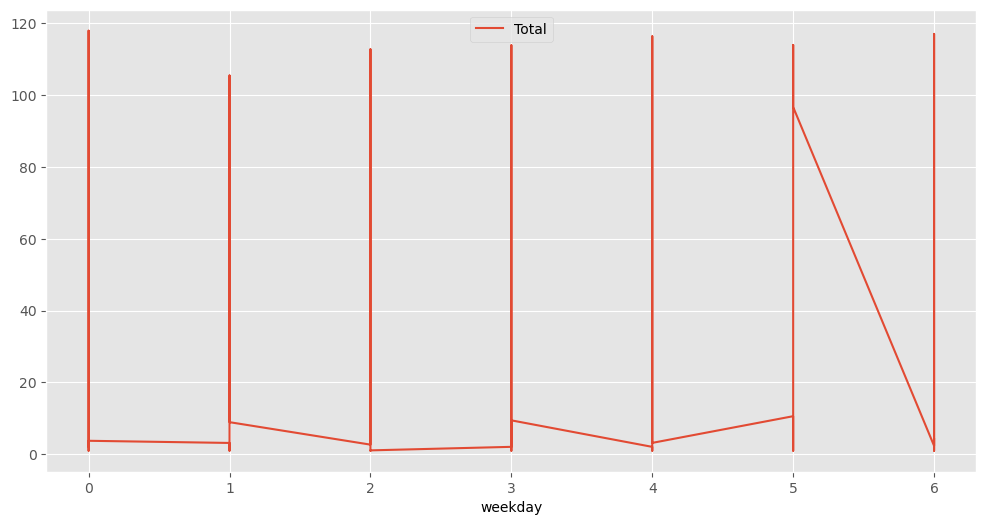

In [1338]:
joined_sort_weekday=joined_df.sort_values(['weekday'],ascending=True)
joined_weekday = joined_sort_weekday.set_index('weekday')
joined_weekday['Total'].plot(legend=True)

Q3

In [1438]:
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

# use sklearn to import a dataset
from sklearn.datasets import load_wine

In [1439]:
ts = pd.read_excel('Assignment 3 - timeseries_data.xlsx').set_index('DATETIME').drop([],axis=1)
ts = ts.rename(columns={"HB_NORTH (RTLMP)": "RTLMP", "ERCOT (WIND_RTI)": "WIND", "ERCOT (GENERATION_SOLAR_RT)": "SOLAR","ERCOT (RTLOAD)":"LOAD"}, errors="raise")
ts['price'] = ts['RTLMP']
ts = ts.drop('RTLMP',axis=1).fillna(0)
# read and process the data

In [1440]:
ts.head(25)

,WIND,SOLAR,LOAD,HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,price
DATETIME,,,,,,,,,
2017-01-01 01:00:00,2155.31,0.00,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017,23.3575
2017-01-01 02:00:00,2313.81,0.00,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017,21.4650
2017-01-01 03:00:00,2587.68,0.00,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017,20.7350
2017-01-01 04:00:00,2748.65,0.00,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017,20.2700
2017-01-01 05:00:00,2757.49,0.00,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017,20.1200
2017-01-01 06:00:00,3032.06,0.00,27701.556228,6,2017-01-01,OFFPEAK,JANUARY,2017,19.7925
2017-01-01 07:00:00,3823.51,0.00,28244.390345,7,2017-01-01,WEPEAK,JANUARY,2017,19.7225
2017-01-01 08:00:00,4419.88,0.54,28955.926493,8,2017-01-01,WEPEAK,JANUARY,2017,19.7375
2017-01-01 09:00:00,6009.27,87.20,29623.127238,9,2017-01-01,WEPEAK,JANUARY,2017,19.2625


In [1441]:
ts.describe

<bound method NDFrame.describe of                         WIND   SOLAR          LOAD  HOURENDING  MARKETDAY  \
DATETIME                                                                    
2017-01-01 01:00:00  2155.31    0.00  29485.791355           1 2017-01-01   
2017-01-01 02:00:00  2313.81    0.00  28911.565913           2 2017-01-01   
2017-01-01 03:00:00  2587.68    0.00  28238.258175           3 2017-01-01   
2017-01-01 04:00:00  2748.65    0.00  27821.000513           4 2017-01-01   
2017-01-01 05:00:00  2757.49    0.00  27646.942413           5 2017-01-01   
...                      ...     ...           ...         ...        ...   
2018-09-17 08:00:00  3195.52    2.04  41902.240000           8 2018-09-17   
2018-09-17 09:00:00  2605.50  111.59  43014.370000           9 2018-09-17   
2018-09-17 10:00:00  2034.80  261.65  45782.550000          10 2018-09-17   
2018-09-17 11:00:00     0.00  464.88  49431.130000          11 2018-09-17   
2018-09-17 12:00:00     0.00    0.00  5234

In [1442]:
ts.info

<bound method DataFrame.info of                         WIND   SOLAR          LOAD  HOURENDING  MARKETDAY  \
DATETIME                                                                    
2017-01-01 01:00:00  2155.31    0.00  29485.791355           1 2017-01-01   
2017-01-01 02:00:00  2313.81    0.00  28911.565913           2 2017-01-01   
2017-01-01 03:00:00  2587.68    0.00  28238.258175           3 2017-01-01   
2017-01-01 04:00:00  2748.65    0.00  27821.000513           4 2017-01-01   
2017-01-01 05:00:00  2757.49    0.00  27646.942413           5 2017-01-01   
...                      ...     ...           ...         ...        ...   
2018-09-17 08:00:00  3195.52    2.04  41902.240000           8 2018-09-17   
2018-09-17 09:00:00  2605.50  111.59  43014.370000           9 2018-09-17   
2018-09-17 10:00:00  2034.80  261.65  45782.550000          10 2018-09-17   
2018-09-17 11:00:00     0.00  464.88  49431.130000          11 2018-09-17   
2018-09-17 12:00:00     0.00    0.00  52347.

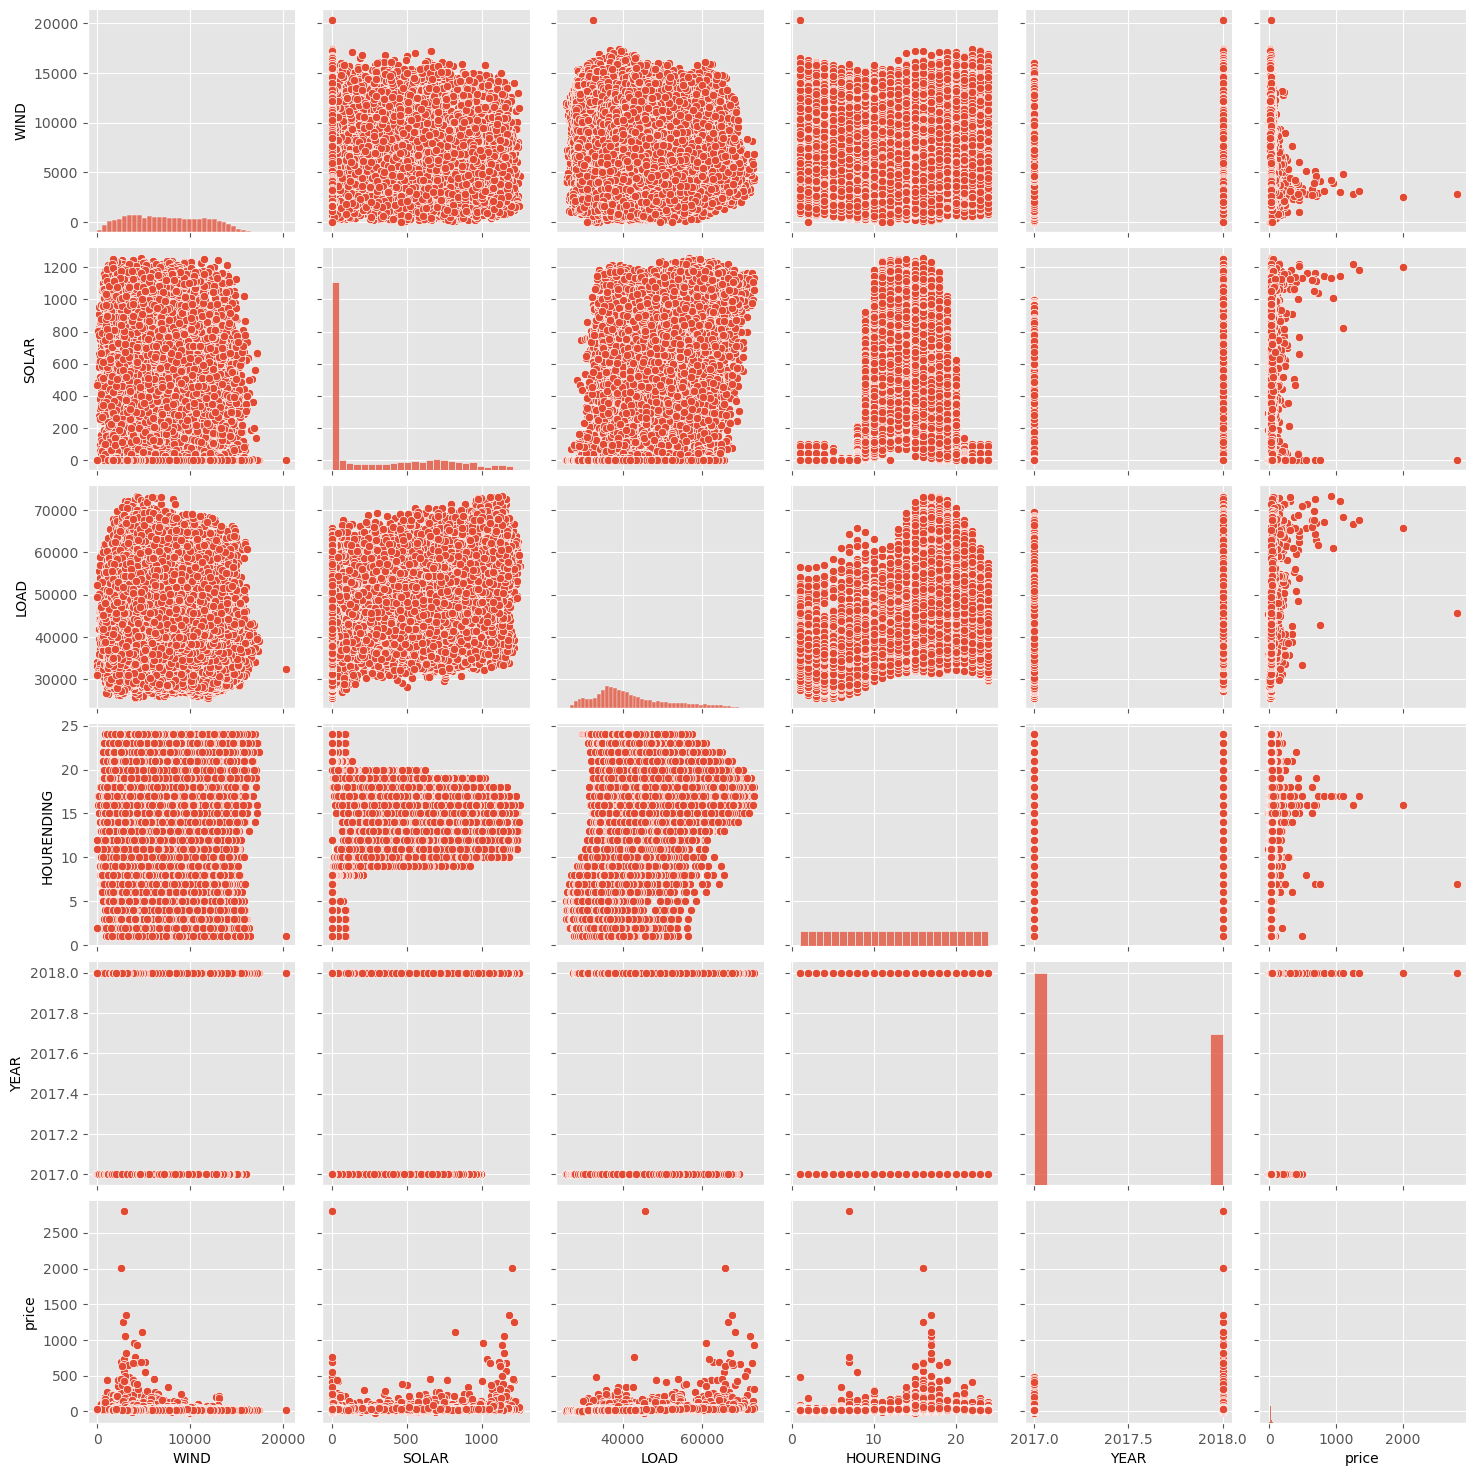

In [1443]:
sns.pairplot(ts)

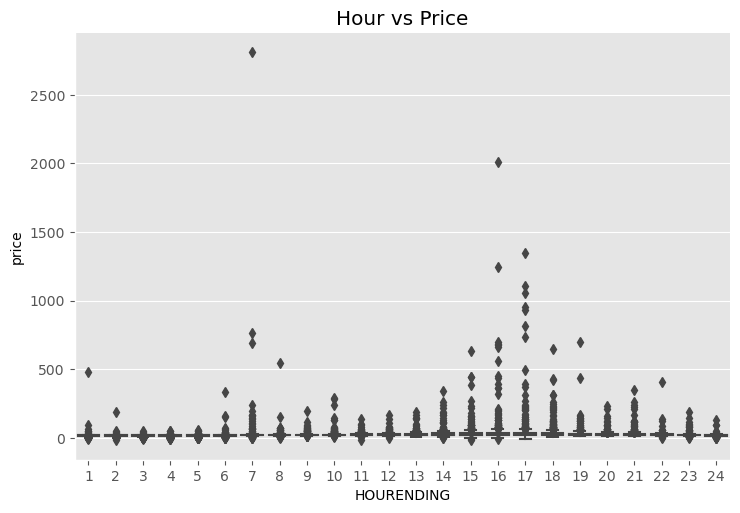

In [1444]:
sns.catplot(x="HOURENDING", y="price", data=ts, kind="box", aspect=1.5)
plt.title("Hour vs Price")
plt.show()

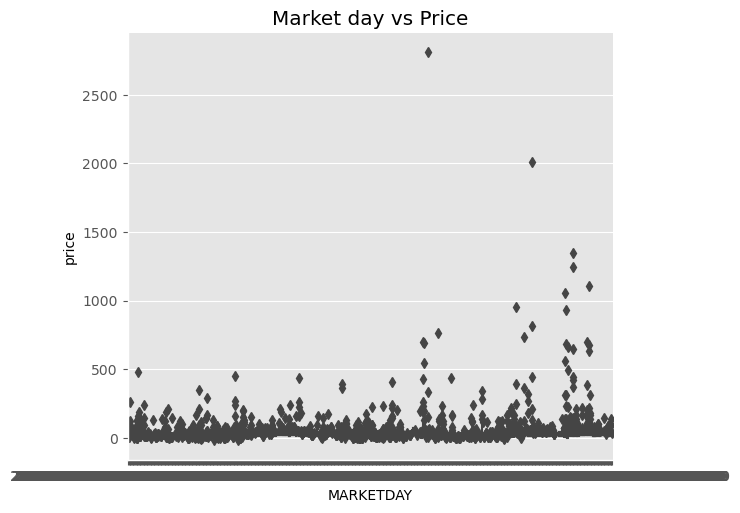

In [1445]:
sns.catplot(x="MARKETDAY", y="price", data=ts, kind="box", aspect=1.5)
plt.title("Market day vs Price")
plt.show()

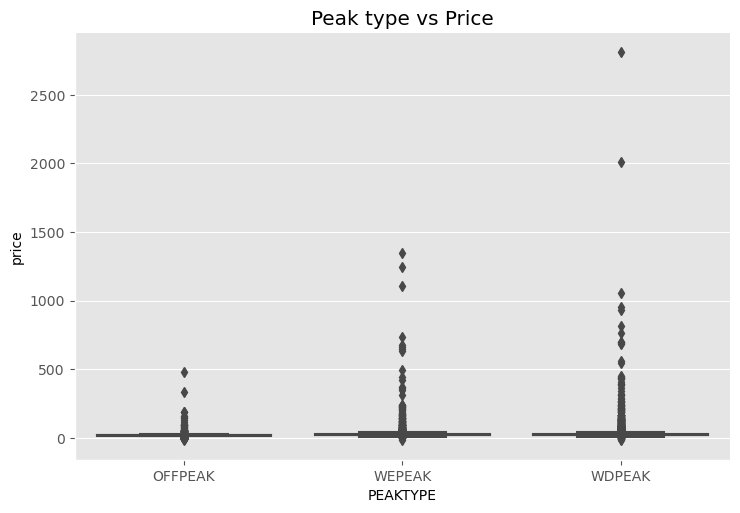

In [1446]:
sns.catplot(x="PEAKTYPE", y="price", data=ts, kind="box", aspect=1.5)
plt.title("Peak type vs Price")
plt.show()

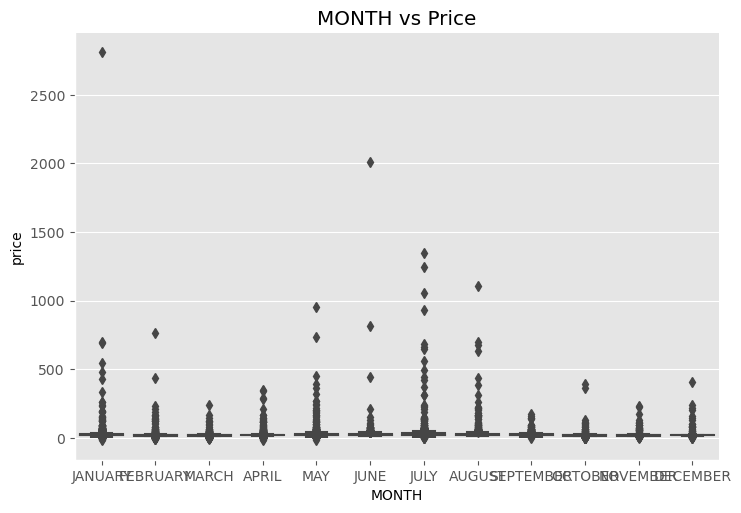

In [1447]:
sns.catplot(x="MONTH", y="price", data=ts, kind="box", aspect=1.5)
plt.title("MONTH vs Price")
plt.show()

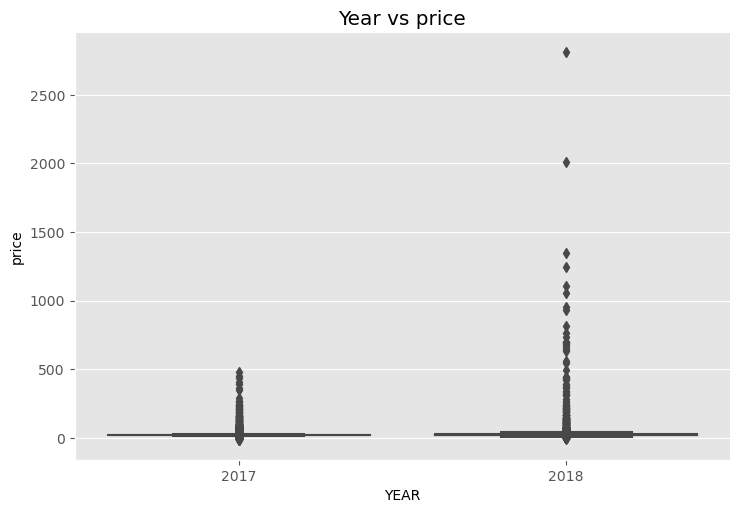

In [1448]:
sns.catplot(x="YEAR", y="price", data=ts, kind="box", aspect=1.5)
plt.title("Year vs price")
plt.show()

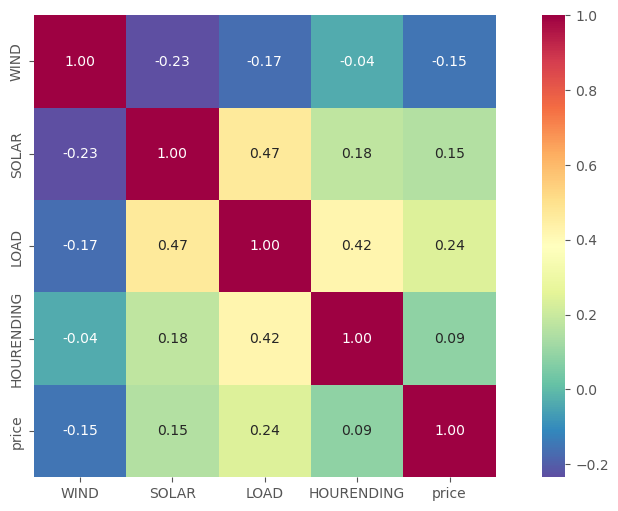

In [1475]:
numerical = ts[["WIND","SOLAR","LOAD","HOURENDING","price"]]
corrmat = numerical.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=numerical.columns, 
                 xticklabels=numerical.columns, 
                 cmap="Spectral_r")
plt.show()

In [1476]:
market_day = (ts['MARKETDAY'])

# Change the market day to numerical variables
market_day_int = [ int(round(i.timestamp())) for i in market_day]
market_day_simplified_int = [int(i - 1483228800)/86400 for i in market_day_int]
ts['numerical_market_day'] = market_day_simplified_int
ts['YEAR'] = ts['YEAR']%2017 
# unifiying the year and market day variable

ts_w_dummies = pd.get_dummies(ts)

y = ts_w_dummies["price"]
x = ts_w_dummies.drop(['MARKETDAY','price','PEAKTYPE_OFFPEAK','MONTH_JANUARY'],axis= 1)
# Here we remove January and offpeak type, since for 3 categories you need 2 dummy variables and for 12 months you need 11 dummy variables
x


,WIND,SOLAR,LOAD,HOURENDING,YEAR,numerical_market_day,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK,MONTH_APRIL,MONTH_AUGUST,MONTH_DECEMBER,MONTH_FEBRUARY,MONTH_JULY,MONTH_JUNE,MONTH_MARCH,MONTH_MAY,MONTH_NOVEMBER,MONTH_OCTOBER,MONTH_SEPTEMBER
DATETIME,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,2155.31,0.00,29485.791355,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,2313.81,0.00,28911.565913,2,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,2587.68,0.00,28238.258175,3,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 04:00:00,2748.65,0.00,27821.000513,4,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 05:00:00,2757.49,0.00,27646.942413,5,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-17 08:00:00,3195.52,2.04,41902.240000,8,1,624.0,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-09-17 09:00:00,2605.50,111.59,43014.370000,9,1,624.0,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-09-17 10:00:00,2034.80,261.65,45782.550000,10,1,624.0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [1477]:
x1 = x[['WIND','SOLAR','LOAD','HOURENDING','YEAR','numerical_market_day']]

def calc_VIF(x):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif_info['Column'] = x.columns
    print (vif_info.sort_values('VIF', ascending=False))
    
calc_VIF(x1)

         VIF                Column
2  16.548629                  LOAD
5  16.058028  numerical_market_day
4   6.545920                  YEAR
3   5.361635            HOURENDING
0   3.924458                  WIND
1   2.125496                 SOLAR


In [1478]:
x2 = x1.drop(['LOAD','numerical_market_day'],axis=1)
calc_VIF(x2)

# remove the VIFs above 5 for collinarity 

        VIF      Column
2  3.030301  HOURENDING
0  2.761840        WIND
3  1.777185        YEAR
1  1.699750       SOLAR


In [1479]:
x = ts_w_dummies.drop(['MARKETDAY','price','PEAKTYPE_OFFPEAK','MONTH_JANUARY','LOAD','numerical_market_day'],axis= 1)
x

,WIND,SOLAR,HOURENDING,YEAR,PEAKTYPE_WDPEAK,PEAKTYPE_WEPEAK,MONTH_APRIL,MONTH_AUGUST,MONTH_DECEMBER,MONTH_FEBRUARY,MONTH_JULY,MONTH_JUNE,MONTH_MARCH,MONTH_MAY,MONTH_NOVEMBER,MONTH_OCTOBER,MONTH_SEPTEMBER
DATETIME,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,2155.31,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,2313.81,0.00,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,2587.68,0.00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 04:00:00,2748.65,0.00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-01 05:00:00,2757.49,0.00,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-17 08:00:00,3195.52,2.04,8,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-09-17 09:00:00,2605.50,111.59,9,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-09-17 10:00:00,2034.80,261.65,10,1,1,0,0,0,0,0,0,0,0,0,0,0,1


In [1480]:
def linear_regression(x,y):
    x= sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
    print_model = model.summary()
    print(print_model)
    
# build a function to run linear regression model    
    
linear_regression(x,y)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     46.52
Date:                Mon, 29 May 2023   Prob (F-statistic):          6.79e-153
Time:                        18:11:23   Log-Likelihood:                -78377.
No. Observations:               14987   AIC:                         1.568e+05
Df Residuals:                   14969   BIC:                         1.569e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.6934      1.661     

In [1481]:
# it looks like we have some factors with insigificant p-values, so let's remove them one by one until all p-values are < 0.05

x_second_edition = x.drop(['MONTH_JULY'],axis= 1)
linear_regression(x_second_edition,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     49.42
Date:                Mon, 29 May 2023   Prob (F-statistic):          1.00e-153
Time:                        18:11:23   Log-Likelihood:                -78377.
No. Observations:               14987   AIC:                         1.568e+05
Df Residuals:                   14970   BIC:                         1.569e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.9998      1.375     

In [1482]:
x_third_edition = x_second_edition.drop(['PEAKTYPE_WEPEAK'],axis= 1)
linear_regression(x_third_edition,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     52.60
Date:                Mon, 29 May 2023   Prob (F-statistic):          3.07e-154
Time:                        18:11:24   Log-Likelihood:                -78378.
No. Observations:               14987   AIC:                         1.568e+05
Df Residuals:                   14971   BIC:                         1.569e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.3649      1.346     

In [1483]:
x_fourth_edition = x_third_edition.drop(['MONTH_MAY'],axis= 1)
linear_regression(x_fourth_edition,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     56.19
Date:                Mon, 29 May 2023   Prob (F-statistic):          1.23e-154
Time:                        18:11:26   Log-Likelihood:                -78379.
No. Observations:               14987   AIC:                         1.568e+05
Df Residuals:                   14972   BIC:                         1.569e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.8155      1.296     

In [1486]:
x_fifth_edition =x_fourth_edition.drop(['PEAKTYPE_WDPEAK'],axis= 1)
linear_regression(x_fifth_edition,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     60.32
Date:                Mon, 29 May 2023   Prob (F-statistic):          5.41e-155
Time:                        18:11:36   Log-Likelihood:                -78380.
No. Observations:               14987   AIC:                         1.568e+05
Df Residuals:                   14973   BIC:                         1.569e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              30.0866      1.285     

In [ ]:
# Finally we have a model with all variables being significant